# Load Dataset

In [6]:
import pandas as pd
from pathlib import Path

csv_path = Path('data') / 'ALL_aun_pacs210914.csv'
print('Attempting to read:', csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found. Current working dir: {Path.cwd()}")

df = pd.read_csv(csv_path)
print('Shape:', df.shape)
df.head()

Attempting to read: data\ALL_aun_pacs210914.csv
Shape: (15366, 164)


,pin,lang,gpaq1,gpaq2,P1,P2,P3a,P3bb,P3b,P4,...,ride_bicycle,by_bicycle,motorbike_three_wheel,sit_car,bus_van_pickup_taxi_schbus,train_metro,ferry,housing,sport_club,opinion_pa
0,1,EN-Bru,3,5,2,0,0,0,0,2,...,0,0,0,1,0,0,0,1,1,NaN
1,2,EN-Bru,2,1,2,0,0,0,0,2,...,0,0,0,0,0,0,0,2,2,NaN
2,3,EN-Bru,0,2,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN
3,4,EN-Bru,7,3,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN
4,5,EN-Bru,4,0,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN


# Analysis: WEMWBS target and PA correlations
This cell computes a combined WEMWBS score, a bottom-quartile binary target, derives key physical-activity numeric features (hours→minutes conversions where needed), and computes Pearson and Spearman correlations between PA features and the WEMWBS total. Results are saved to `data/pa_wemwbs_correlations.csv`.

In [7]:
# Analysis cell -- compute targets, derive PA features, compute correlations
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
import json

# Ensure dataframe is loaded (previous cell creates `df`)
if 'df' not in globals():
    csv_path = Path('data') / 'ALL_aun_pacs210914.csv'
    df = pd.read_csv(csv_path, na_values=['NA'])

# Identify WEMWBS items present
wem_cols = [f'wemwbs{i}' for i in range(1,8) if f'wemwbs{i}' in df.columns]
if not wem_cols:
    raise RuntimeError('No WEMWBS items found in dataframe (wemwbs1..7)')

# Compute total and mean (require at least 4 items present to compute total reliably)
df[wem_cols] = df[wem_cols].apply(pd.to_numeric, errors='coerce')
df['wemwbs_total'] = df[wem_cols].sum(axis=1, skipna=False)
df['wemwbs_n_nonnull'] = df[wem_cols].notna().sum(axis=1)
# Option: require >=4 non-missing items to keep the row for target computation
df.loc[df['wemwbs_n_nonnull'] < 4, 'wemwbs_total'] = np.nan

# Binary low-wellbeing target: bottom quartile among non-missing totals
q1 = df['wemwbs_total'].quantile(0.25)
df['wemwbs_bin'] = (df['wemwbs_total'] <= q1).astype('Int64')

# Helper to convert hour fields to minutes if present
def hours_to_min(df, col):
    if col in df.columns:
        df[col + '_min'] = pd.to_numeric(df[col], errors='coerce') * 60

# Convert common 'hours' columns reported in notebook/data_dict
for hcol in ['P3a','P6a','P9a','P12a','P15a']:
    hours_to_min(df, hcol)

# Ensure minute columns are numeric for minute-based fields (P3b, P6b etc.)
for mcol in ['P3b','P6b','P9b','P12b','P15b','gpaq_sedent_m','gpaq1','gpaq2','hrs_slept','sport_total']:
    if mcol in df.columns:
        df[mcol] = pd.to_numeric(df[mcol], errors='coerce')

# Create an MVPA_total estimate from available minute columns (prefer *_min then *_b)
mvpa_parts = []
for prefix in ['P3','P6','P9','P12','P15']:
    if prefix + 'a_min' in df.columns:
        mvpa_parts.append(prefix + 'a_min')
    if prefix + 'b' in df.columns:
        mvpa_parts.append(prefix + 'b')
# Remove duplicates and keep only existing columns
mvpa_parts = [c for i,c in enumerate(mvpa_parts) if c in df.columns]
df['mvpa_total_min'] = df[mvpa_parts].sum(axis=1, skipna=True) if mvpa_parts else np.nan

# Candidate PA numeric features to correlate (select present columns)
candidate_pa = [c for c in ['mvpa_total_min','sport_total','gpaq_sedent_m','gpaq1','gpaq2','hrs_slept'] if c in df.columns or c=='mvpa_total_min']
candidate_pa = [c for c in candidate_pa if c in df.columns or c=='mvpa_total_min']
# Add any other numeric columns whose names begin with common PA prefixes
for c in df.columns:
    low = c.lower()
    if low.startswith(('run_jog','cycle','aerodance','ballgame','racquet','athletics','watersport','fightsport','p','gpaq')) and c not in candidate_pa:
        # include if numeric-like
        try:
            pd.to_numeric(df[c], errors='raise')
            candidate_pa.append(c)
        except Exception:
            pass

# Correlation calculations
results = []
for feat in candidate_pa:
    x = pd.to_numeric(df[feat], errors='coerce')
    valid = x.notna() & df['wemwbs_total'].notna()
    if valid.sum() < 10:
        continue
    pr, pp = st.pearsonr(x[valid], df.loc[valid, 'wemwbs_total'])
    sr, sp = st.spearmanr(x[valid], df.loc[valid, 'wemwbs_total'])
    # point-biserial via pearson between numeric feat and binary target
    valid_bin = x.notna() & df['wemwbs_bin'].notna()
    if valid_bin.sum() >= 10:
        br, bp = st.pearsonr(x[valid_bin], df.loc[valid_bin, 'wemwbs_bin'].astype(float))
    else:
        br, bp = (np.nan, np.nan)
    results.append({'feature': feat, 'pearson_r': pr, 'pearson_p': pp, 'spearman_r': sr, 'spearman_p': sp, 'biserial_r': br, 'biserial_p': bp, 'n': int(valid.sum())})

res_df = pd.DataFrame(results).sort_values(by='pearson_r', key=lambda s: s.abs(), ascending=False)

# Add feature descriptions to the correlation results
def get_feature_description(feature_name):
    data_dict_path = Path('data') / 'data_dictionary.json'
    if data_dict_path.exists():
        with open(data_dict_path, 'r') as f:
            descriptions = json.load(f)
        return descriptions.get(feature_name, 'Description not available')
    else:
        print(f"Warning: {data_dict_path} not found. Using default descriptions.")
        default_descriptions = {
            'mvpa_total_min': 'Total minutes of moderate-to-vigorous physical activity',
            'sport_total': 'Total minutes spent on sports activities',
            'gpaq_sedent_m': 'Minutes spent in sedentary activities (GPAQ)',
            'gpaq1': 'GPAQ question 1 response',
            'gpaq2': 'GPAQ question 2 response',
            'hrs_slept': 'Hours of sleep per day'
        }
        return default_descriptions.get(feature_name, 'Description not available')

res_df['desc'] = res_df['feature'].apply(get_feature_description)

# Summary stats for WEMWBS total
wem_summary = df['wemwbs_total'].describe()
print('WEMWBS total summary: ', wem_summary)

# Save the updated results to CSV
output_path = Path('data') / 'pa_wemwbs_correlations.csv'
res_df.to_csv(output_path, index=False)
print(f"Updated correlation results saved to {output_path}")

# Show top correlations
display(res_df.head(20))

WEMWBS total summary:  count    15366.000000
mean        23.472862
std          4.589098
min          7.000000
25%         21.000000
50%         24.000000
75%         27.000000
max         35.000000
Name: wemwbs_total, dtype: float64
Updated correlation results saved to data\pa_wemwbs_correlations.csv


,feature,pearson_r,pearson_p,spearman_r,spearman_p,biserial_r,biserial_p,n,desc
80,panes2,-0.149789,8.412543e-78,-0.173942,1.170536e-104,0.130950,9.644032e-60,15366,"{'question_number': 'Q30', 'description': 'Ove..."
3,gpaq1,0.142050,4.433472e-70,0.148172,3.742563e-76,-0.100598,7.389352e-36,15366,"{'question_number': 'Q7', 'description': 'In t..."
83,panes5,-0.132636,2.949980e-61,-0.131764,1.799258e-60,0.096985,1.948887e-33,15366,"{'question_number': 'Q33', 'description': 'Gen..."
82,panes4,-0.127373,1.353661e-56,-0.139805,6.419410e-68,0.104328,1.886468e-38,15366,"{'question_number': 'Q32', 'description': 'How..."
28,P14,0.122424,2.179200e-52,0.137190,1.905348e-65,-0.089906,5.949620e-29,15366,"{'question_number': 'Q24', 'description': 'In ..."
27,P13,-0.122312,2.700009e-52,-0.124440,4.417653e-54,0.094673,6.188208e-32,15366,"{'question_number': 'Q23', 'description': 'Do ..."
86,panes8,-0.115757,5.451622e-47,-0.117515,2.199793e-48,0.093740,2.442770e-31,15366,"{'question_number': 'Q36', 'description': 'Do ..."
84,panes6,-0.102101,6.846581e-37,-0.102285,5.099644e-37,0.092974,7.462000e-31,15366,"{'question_number': 'Q34', 'description': 'Doe..."
30,P15bb,0.101370,2.187291e-36,0.115415,1.011094e-46,-0.074678,1.874194e-20,15366,"{'question_number': None, 'description': 'Conv..."
93,P15a_min,0.101370,2.187291e-36,0.115415,1.011094e-46,-0.074678,1.874194e-20,15366,"{'question_number': 'Q25#1_1', 'description': ..."


# Feature Engineering Step
This step preprocesses the dataset by handling missing values, scaling numeric features, and encoding categorical features. The preprocessing pipeline ensures the data is ready for modeling.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
# Extract target and drop rows with missing target to avoid leakage
if 'wemwbs_bin' in df.columns:
    y = df['wemwbs_bin']
    keep_idx = y.notna()
    y = y.loc[keep_idx]
    df = df.loc[keep_idx].copy()
    print(f'Extracted target "wemwbs_bin" and kept {df.shape[0]} rows')
else:
    raise RuntimeError('Target column "wemwbs_bin" not found. Run the analysis cell first.')
# Drop environment-related columns that start with 'panes' first (these are not features)
panes_cols = [c for c in df.columns if c.lower().startswith('panes')]
if panes_cols:
    print('Dropping environment-related columns:', panes_cols)
    df = df.drop(columns=panes_cols)
else:
    print("No 'panes*' columns found to drop.")
df = df.drop(columns='pin')  # Droping pin column as it only serves as identifier
# If a correlation results dataframe `res_df` exists, use its top 50 features to subset `df`
selected_features = None
if 'res_df' in globals() and isinstance(res_df, (pd.DataFrame,)) and 'feature' in res_df.columns:
    top50 = res_df['feature'].head(50).tolist()
    print('Top 50 features from res_df (requested):', top50)
    # Keep only features that exist in df
    use_cols = [c for c in top50 if c in df.columns]
    missing = [c for c in top50 if c not in df.columns]
    if missing:
        print('Warning - these top features were not found in df and will be skipped:', missing)
    # Ensure common derived PA columns are included if present (e.g., mvpa_total_min)
    for derived in ['mvpa_total_min','sport_total','gpaq_sedent_m','hrs_slept']:
        if derived in df.columns and derived not in use_cols:
            use_cols.append(derived)
    if not use_cols:
        print('No top50 features present in dataframe; keeping all columns instead.')
        X_df = df.copy()
    else:
        selected_features = use_cols
        # IMPORTANT: do not include the target column in X_df
        X_df = df[use_cols].copy()
        print('X_df.shape after subsetting to top50 features (rows, cols):', X_df.shape)
else:
    print("No 'res_df' with a 'feature' column found; not subsetting by top50.")
    X_df = df.copy()
# Show remaining columns (first 50 for readability)
print('Feature columns count:', len(X_df.columns))
print('Sample feature columns:', list(X_df.columns[:50]))
# Identify numeric and categorical features from the feature-only DataFrame
numeric_features = X_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) ,
    ('scaler', StandardScaler())
])
# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')) ,
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Apply the preprocessing pipeline to feature-only DataFrame
processed_X = preprocessor.fit_transform(X_df)
print("Preprocessing complete. Transformed data shape:", processed_X.shape)
# Save feature names for later mapping (SHAP / importances)
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = None
if feature_names is not None:
    joblib.dump(feature_names, 'feature_names.pkl')
    print('Saved feature names to feature_names.pkl')

Extracted target "wemwbs_bin" and kept 15366 rows
Dropping environment-related columns: ['panes1', 'panes2', 'panes3', 'panes4', 'panes5', 'panes6', 'panes7', 'panes8', 'panes9', 'panes10']
Top 50 features from res_df (requested): ['panes2', 'gpaq1', 'panes5', 'panes4', 'P14', 'P13', 'panes8', 'panes6', 'P15bb', 'P15a_min', 'P15a', 'panes10', 'mvpa_total_min', 'panes9', 'panes7', 'P15b', 'sport_total', 'panes1', 'P10', 'P11', 'gpaq_sedent_h', 'gpaq_sedent_m', 'ballgame', 'cycle', 'watersport', 'P12b', 'P12bb', 'P12a', 'P12a_min', 'athletics', 'P8', 'racquet', 'ballgame_wkdy', 'fightsport', 'gpaq_sedent_h_cat', 'P9b', 'P9a', 'P9a_min', 'P9bb', 'fightsport_wkend', 'aerodance_wkend', 'aerodance_wkdy_t', 'cycle_wkend', 'run_jog_wkend_t', 'cycle_wkdy_t', 'aerodance_wkdy', 'athletics_wkdy', 'gpaq2', 'fightsport_wkdy_t', 'pin']
Warning - these top features were not found in df and will be skipped: ['panes2', 'panes5', 'panes4', 'panes8', 'panes6', 'panes10', 'panes9', 'panes7', 'panes1', 'pin


RandomForest Evaluation:

Best RandomForest pipeline saved as 'best_RandomForest_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      2089
         1.0       0.42      0.48      0.45       985

    accuracy                           0.62      3074
   macro avg       0.58      0.58      0.58      3074
weighted avg       0.63      0.62      0.62      3074

Best RandomForest pipeline saved as 'best_RandomForest_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      2089
         1.0       0.42      0.48      0.45       985

    accuracy                           0.62      3074
   macro avg       0.58      0.58      0.58      3074
weighted avg       0.63      0.62      0.62      3074



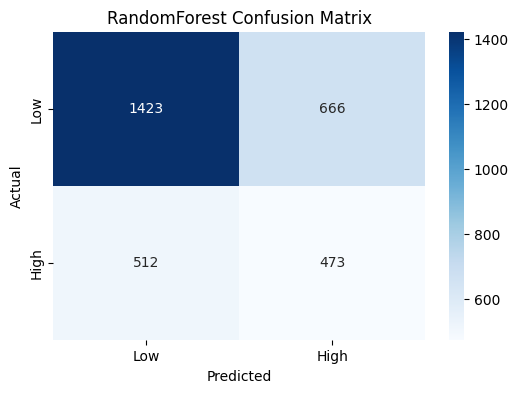

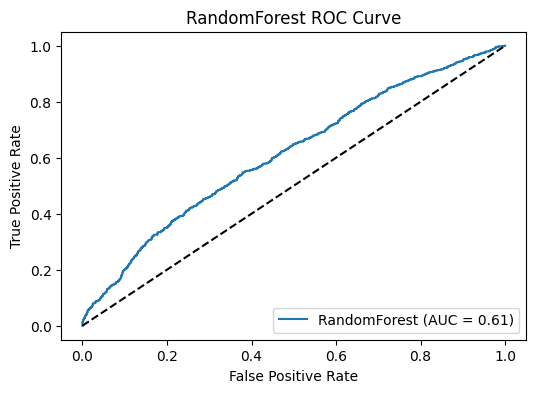

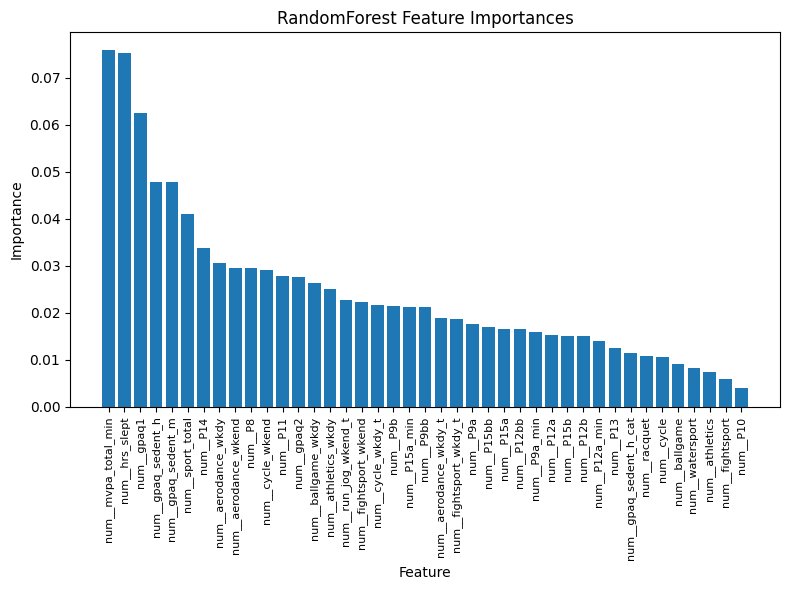

- Top features influencing the model:
  num__mvpa_total_min: Importance 0.0758
  num__hrs_slept: Importance 0.0753
  num__gpaq1: Importance 0.0625
  num__gpaq_sedent_h: Importance 0.0479
  num__gpaq_sedent_m: Importance 0.0477
  num__sport_total: Importance 0.0410
  num__P14: Importance 0.0338
  num__aerodance_wkdy: Importance 0.0305
  num__aerodance_wkend: Importance 0.0296
  num__P8: Importance 0.0296

KNN Evaluation:
Best KNN pipeline saved as 'best_KNN_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      2089
         1.0       0.40      0.33      0.36       985

    accuracy                           0.63      3074
   macro avg       0.56      0.55      0.55      3074
weighted avg       0.61      0.63      0.62      3074

Best KNN pipeline saved as 'best_KNN_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74   

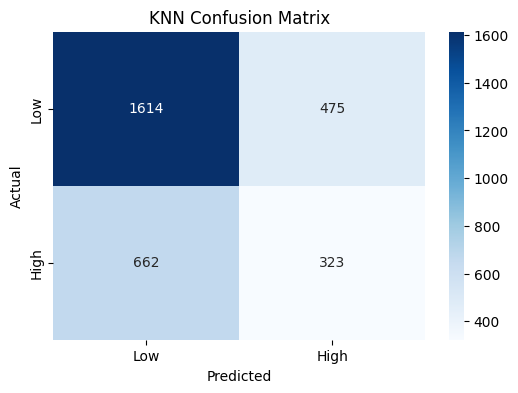

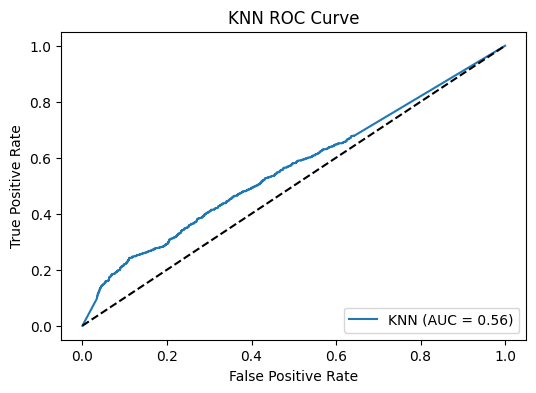


XGBoost Evaluation:
Set XGBoost scale_pos_weight=2.12
Best XGBoost pipeline saved as 'best_XGBoost_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.51      0.61      2089
         1.0       0.37      0.61      0.46       985

    accuracy                           0.54      3074
   macro avg       0.55      0.56      0.53      3074
weighted avg       0.62      0.54      0.56      3074

Best XGBoost pipeline saved as 'best_XGBoost_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.51      0.61      2089
         1.0       0.37      0.61      0.46       985

    accuracy                           0.54      3074
   macro avg       0.55      0.56      0.53      3074
weighted avg       0.62      0.54      0.56      3074



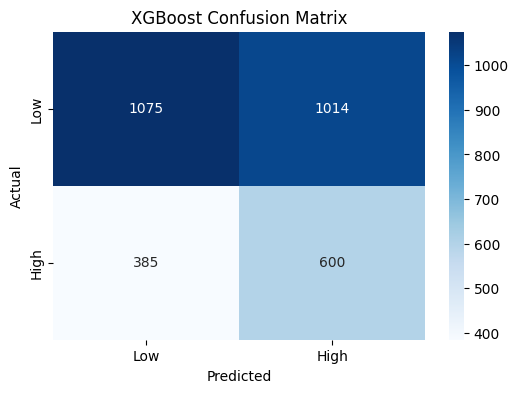

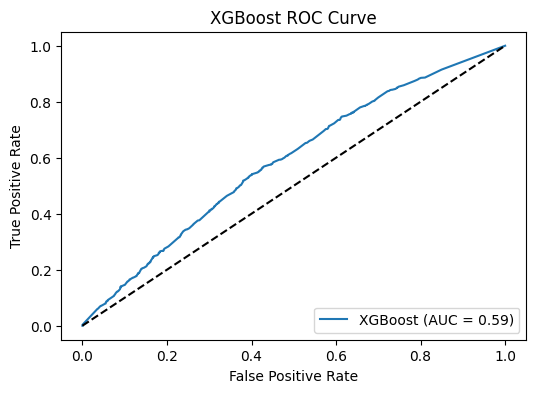

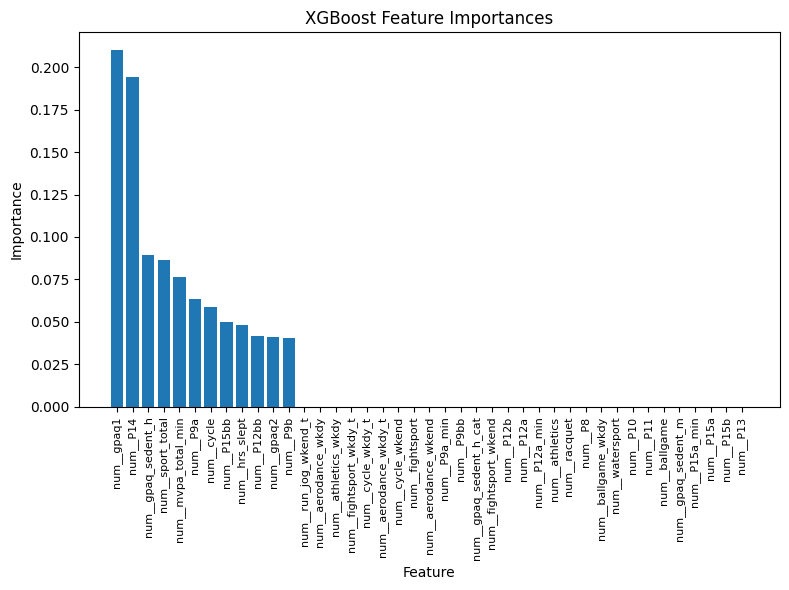

- Top features influencing the model:
  num__gpaq1: Importance 0.2101
  num__P14: Importance 0.1942
  num__gpaq_sedent_h: Importance 0.0894
  num__sport_total: Importance 0.0866
  num__mvpa_total_min: Importance 0.0764
  num__P9a: Importance 0.0632
  num__cycle: Importance 0.0588
  num__P15bb: Importance 0.0502
  num__hrs_slept: Importance 0.0481
  num__P12bb: Importance 0.0417


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Split the data into training and testing sets
X = processed_X
y = y.values  # aligned target array
# Use stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Use stratified K-fold for cross-validation and prioritize recall
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Define classifiers and their hyperparameter grids (add class-weight for RF)
classifiers = {
    'RandomForest': (RandomForestClassifier(class_weight='balanced', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'XGBoost': (XGBClassifier(eval_metric='logloss', verbosity=0), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    })
}
# Attempt to get feature names (sklearn >=1.0) for interpretation/importance mapping
try:
    feature_names = joblib.load('feature_names.pkl')
except Exception:
    try:
        feature_names = preprocessor.get_feature_names_out()
    except Exception:
        feature_names = None
# Perform hyperparameter tuning and evaluate models (scoring='recall')
for name, (model, params) in classifiers.items():
    print(f"\n{name} Evaluation:")
    # For XGBoost set scale_pos_weight based on training labels to handle imbalance
    if name == 'XGBoost':
        n_pos = int((y_train == 1).sum())
        n_neg = int((y_train == 0).sum())
        if n_pos == 0:
            scale_pos_weight = 1
        else:
            scale_pos_weight = float(n_neg) / float(max(1, n_pos))
        model.set_params(scale_pos_weight=scale_pos_weight)
        print(f'Set XGBoost scale_pos_weight={scale_pos_weight:.2f}')
    grid_search = GridSearchCV(model, params, cv=cv, scoring='recall')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    # Save the full pipeline (preprocessor + trained model) to avoid mismatches later
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', best_model)])
    joblib.dump(pipeline, f'best_{name}_pipeline.pkl')
    if feature_names is not None:
        joblib.dump(feature_names, f'feature_names_{name}.pkl')
    print(f"Best {name} pipeline saved as 'best_{name}_pipeline.pkl'")
    
    # Predictions and classification report
    y_pred = best_model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    
    # Feature importance (if applicable) - print names if available
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 6))
        # map indices to names when possible
        if feature_names is not None and len(feature_names) == len(importances):
            names = [feature_names[i] for i in indices]
            plt.bar(range(len(importances)), importances[indices], align='center')
            plt.xticks(range(len(importances)), names, rotation=90, fontsize=8)
        else:
            plt.bar(range(len(importances)), importances[indices], align='center')
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
        # Print top named features
        print('- Top features influencing the model:')
        for i in range(min(10, len(importances))):
            idx = indices[i]
            fname = feature_names[idx] if feature_names is not None and idx < len(feature_names) else f'feature_{idx}'
            print(f"  {fname}: Importance {importances[idx]:.4f}")

# Shap Interpretation

In [ ]:
import shap
import matplotlib.pyplot as plt
import joblib
import pandas as pd

print('\nSHAP Interpretation Phase:', flush=True)
shap.initjs()
for name, (model, params) in classifiers.items():
    print(f"\n{name} Interpretation on Best Model:")
    pipeline_path = f'best_{name}_pipeline.pkl'
    best_model = None
    preprocessor_loaded = None
    try:
        pipeline = joblib.load(pipeline_path)
        print(f'Loaded pipeline from {pipeline_path}')
        if hasattr(pipeline, 'named_steps') and 'model' in pipeline.named_steps:
            best_model = pipeline.named_steps['model']
            preprocessor_loaded = pipeline.named_steps.get('preprocessor', None)
        else:
            best_model = pipeline
    except Exception as e:
        print('Failed to load pipeline, attempting to load model-only:', e)
        try:
            best_model = joblib.load(f'best_{name}_model.pkl')
        except Exception as e2:
            print('Also failed to load model-only:', e2)
            best_model = None
    # Attempt to get feature names from per-model file, fallback to global file or preprocessor
    try:
        feature_names = joblib.load(f'feature_names_{name}.pkl')
    except Exception:
        try:
            feature_names = joblib.load('feature_names.pkl')
        except Exception:
            try:
                if preprocessor_loaded is not None:
                    feature_names = preprocessor_loaded.get_feature_names_out()
                else:
                    feature_names = preprocessor.get_feature_names_out()
            except Exception:
                feature_names = None
    try:
        X_train_df = pd.DataFrame(X_train, columns=feature_names) if feature_names is not None else X_train
        X_test_df = pd.DataFrame(X_test, columns=feature_names) if feature_names is not None else X_test
    except Exception:
        X_train_df = X_train
        X_test_df = X_test
    if best_model is None:
        print('No model available for SHAP interpretation for', name)
        continue
    
        
    shap_values = None
    try:
      if(name == "RandomForest"):
          explainer = shap.TreeExplainer(best_model)
          shap_values = explainer.shap_values(X_test_df.iloc[:50])
      elif(name == "XGBoost"):
          explainer = shap.TreeExplainer(best_model.get_booster())
          shap_values = explainer.shap_values(X_test_df)
      # elif(name== "KNN"):
          # background = shap.sample(X_train_df, 100)
          # explainer = shap.KernelExplainer(
          #     best_model.predict_proba,
          #     shap.sample(X_train_df, 100)   # background
          # )
          # shap_values = explainer.shap_values(X_test_df)
    except Exception as e:
      print("Failed SHAP for", name, ":", e)
      continue

    print(f"SHAP values computed for {name}: {shap_values is not None}")
    if shap_values is None:
        continue
    try:
        shap.summary_plot(shap_values, X_test_df, max_display=20, show=False)
        plt.title(f'{name} SHAP Summary Plot')
        plt.show()
    except Exception as e:
        print("Plot error:", e)


SHAP Interpretation Phase:



RandomForest Interpretation on Best Model:
Loaded pipeline from best_RandomForest_pipeline.pkl


C:\Users\Palador-L014\AppData\Local\Temp\ipykernel_48980\4232826782.py:75: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, max_display=20, show=False)
C:\Users\Palador-L014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


SHAP values computed for RandomForest: True
Plot error: Feature and SHAP matrices must have the same number of rows!

KNN Interpretation on Best Model:
Loaded pipeline from best_KNN_pipeline.pkl


  1%|          | 18/3074 [02:07<6:43:47,  7.93s/it]